In [ ]:
# Reproducible Analysis

## CASA0013: Foundations of Spatial Data Science

### Student Ids: ucfnlui, ucftYYYY, etc.

In [ ]:
### ucfnlui code:

In [1]:
print("start from here")

start from here


In [2]:
from pathlib import Path

import requests
from tqdm import tqdm

import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import altair as alt

In [6]:
DATA_PATH = Path('data/')
listings_df = pd.read_csv(DATA_PATH/'listings_summary.csv',
                          parse_dates=['last_review'])
listings_detail_df = pd.read_csv(DATA_PATH/'listings.csv', low_memory=False,
                                 parse_dates=['host_since', 
                                              'last_scraped', 'calendar_last_scraped',
                                              'first_review', 'last_review'])

reviews_df = pd.read_csv(DATA_PATH/'reviews_summary.csv', parse_dates=['date'])
reviews_detail_df = pd.read_csv(DATA_PATH/'reviews.csv', parse_dates=['date'])

calendar_df = pd.read_csv(DATA_PATH/'calendar.csv', parse_dates=['date'])

neighbourhoods_df = pd.read_csv(DATA_PATH/'neighbourhoods.csv')
gdf = gpd.read_file(DATA_PATH/'neighbourhoods.geojson')

In [17]:
review_cols = ['review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
               'review_scores_communication', 'review_scores_location', 'review_scores_value']
host_cols = ['host_since', 'host_response_time',
             'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified']

listing_detail_cols = ['id', 'instant_bookable', 'neighbourhood_cleansed', 'room_type'] + review_cols + host_cols 


res_listings_detail_df = listings_detail_df
res_listings_detail_df = res_listings_detail_df[res_listings_detail_df['host_name'].notnull()]
res_listings_detail_df = res_listings_detail_df[res_listings_detail_df.filter(regex='review_scores').notnull().all(axis=1)]
res_listings_detail_df = res_listings_detail_df[listing_detail_cols].rename({'neighbourhood_cleansed': 'neighbourhood'}, axis=1)
res_listings_detail_df.head()

,id,instant_bookable,neighbourhood,room_type,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,host_since,host_response_time,host_is_superhost,host_has_profile_pic,host_identity_verified
0,13913.0,f,Islington,Private room,4.82,4.89,4.86,4.93,4.75,4.82,2009-11-16,within a day,f,t,t
1,15400.0,f,Kensington and Chelsea,Entire home/apt,4.84,4.88,4.87,4.82,4.93,4.73,2009-12-05,within an hour,f,t,t
2,284532.0,f,Tower Hamlets,Entire home/apt,4.53,4.03,4.72,4.86,4.72,4.31,2011-12-07,within a day,f,t,t
3,106332.0,f,Tower Hamlets,Private room,4.91,4.71,4.93,4.93,4.92,4.83,2010-10-17,within a few hours,t,t,t
4,17402.0,f,Westminster,Entire home/apt,4.82,4.69,4.69,4.69,4.88,4.59,2010-01-04,within a few hours,f,t,t


In [22]:
geo_cols = ['neighbourhood', 'geometry']
res_gdf = gdf.loc[:, geo_cols]
res_gdf.head()

,neighbourhood,geometry
0,Kingston upon Thames,"MULTIPOLYGON (((-0.33068 51.32901, -0.33059 51..."
1,Croydon,"MULTIPOLYGON (((-0.06402 51.31864, -0.06407 51..."
2,Bromley,"MULTIPOLYGON (((0.01213 51.29960, 0.01196 51.2..."
3,Hounslow,"MULTIPOLYGON (((-0.24456 51.48870, -0.24468 51..."
4,Ealing,"MULTIPOLYGON (((-0.41183 51.53408, -0.41188 51..."


In [21]:
binary_cols = ['instant_bookable', 'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified']
binary_map = {'f': False, 't': True}
res_listings_detail_df[binary_cols] = res_listings_detail_df[binary_cols].apply(lambda x: x.map(binary_map)).astype(bool)

cat_type = pd.api.types.CategoricalDtype(['not specified', 'within an hour', 'within a few hours', 'within a day', 'a few days or more'])
res_listings_detail_df['host_response_time'] = res_listings_detail_df['host_response_time'].fillna('not specified').astype(cat_type)

In [25]:
res_gdf['area_sq_km'] = (res_gdf['geometry'].to_crs({'init': 'epsg:3395'})
                                    .map(lambda p: p.area / 10**6))

res_listings_detail_df['age'] = (pd.Timestamp('now') - pd.to_datetime(res_listings_detail_df['host_since'])).dt.days.div(365.25).round(2)

/opt/conda/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [26]:
geo_listings_df = res_gdf.merge(res_listings_detail_df, how='inner', on='neighbourhood')

geo_listings_df['listings_count'] = geo_listings_df.groupby('neighbourhood')['id'].transform('count')
geo_listings_df['listings_density'] = geo_listings_df.groupby('neighbourhood')['area_sq_km'].transform(lambda x: len(x) / x)

geo_listings_df['mean_review_scores_accuracy'] = geo_listings_df.groupby('neighbourhood')['review_scores_accuracy'].transform('mean')
geo_listings_df['mean_review_scores_cleanliness'] = geo_listings_df.groupby('neighbourhood')['review_scores_cleanliness'].transform('mean')
geo_listings_df['mean_review_scores_checkin'] = geo_listings_df.groupby('neighbourhood')['review_scores_checkin'].transform('mean')
geo_listings_df['mean_review_scores_communication'] = geo_listings_df.groupby('neighbourhood')['review_scores_communication'].transform('mean')
geo_listings_df['mean_review_scores_location'] = geo_listings_df.groupby('neighbourhood')['review_scores_location'].transform('mean')
geo_listings_df['mean_review_scores_value'] = geo_listings_df.groupby('neighbourhood')['review_scores_value'].transform('mean')

geo_listings_df['mean_review_scores_all'] = geo_listings_df.filter(like='mean_review_scores').mean(axis=1)

In [32]:
review_cols = ['mean_review_scores_accuracy', 'mean_review_scores_cleanliness', 'mean_review_scores_checkin',
               'mean_review_scores_communication', 'mean_review_scores_location', 'mean_review_scores_value']
review_titles = ['Accuracy', 'Cleanliness', 'Check-in',
                 'Communication', 'Location', 'Value']
review_map = {col: title for col, title in zip(review_cols, review_titles)}

result_df = geo_listings_df[['geometry', 'neighbourhood', 'mean_review_scores_all'] + review_cols].drop_duplicates()

def gen_map_chart(df, review_col, review_title):
    '''Generate choropleth map
    
    Generate choropleth map based on scores of specific review types
    
    :param df: DataFrame with necessary geo data and review scores for different neighbourhood
    :type df: DataFrame
    :param review_col: name of review scores type
    :type review_col: str
    :param review_title: title of review scores type
    :type review_title: str
    :return: Altair Chart for displaying 
    :rtype: Chart
    '''
    chart = alt.Chart(
        df,
        title=review_title
    ).mark_geoshape().encode(
        color=f'{review_col}:Q',
        tooltip=['neighbourhood:N', f'{review_col}:Q']
    ).properties(
        width=250, 
        height=250,
    )
    return chart

charts = []

for review_col, review_title in zip(review_cols, review_titles):
    charts.append(gen_map_chart(result_df, review_col, review_title))

overall_map_chart = gen_map_chart(result_df, 'mean_review_scores_all', 'Overall')

((alt.vconcat(alt.concat(*charts, columns=3), overall_map_chart, 
              title='Average review scores by neighbourhood', 
              center=True)
     .configure_view(strokeWidth=0)
     .configure_title(fontSize=18)
     .configure_legend(title=None, orient='top',  labelFontSize=12)))


SchemaValidationError: Invalid specification

        altair.vegalite.v4.api.Chart, validating 'additionalProperties'

        Additional properties are not allowed ('visual_range', 'visual_text_color' were unexpected)
        

alt.VConcatChart(...)

In [ ]:
### ucfniul code:

In [ ]:
print("start from here")

In [8]:
import csv
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import os
from requests import get
from urllib.parse import urlparse

In [3]:
#Read in data of airbnb listings and london boroughs
data = pd.read_csv("http://data.insideairbnb.com/united-kingdom/england/london/2022-09-10/visualisations/listings.csv")
#print(data.head())
data.set_index('id', inplace=True)
london = gpd.read_file("http://data.insideairbnb.com/united-kingdom/england/london/2022-09-10/visualisations/neighbourhoods.geojson", drivers='GPKG')

epsg:4326


<AxesSubplot:>

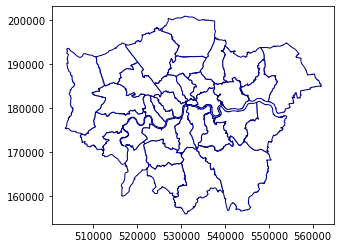

In [4]:
#Change the crs and plot london borough to check the data
print(london.crs)
london = london.to_crs('epsg:27700')
london.plot(facecolor='white', edgecolor='darkblue')

<AxesSubplot:>

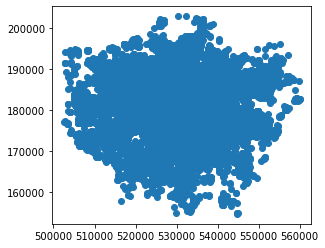

In [5]:
#Converting listings to a geodataframe by using the coordinates
gdf = gpd.GeoDataFrame(data, 
            geometry=gpd.points_from_xy(
                        data['longitude'], 
                        data['latitude'], 
                        crs='epsg:4326'
            )
      )
#Change the crs and plot
gdf = gdf.to_crs('epsg:27700')
gdf.plot()

In [28]:
#Download the OSM data:
#!wget http://download.geofabrik.de/europe/great-britain/england/greater-london-latest-free.shp.zip
#!unzip greater-london-latest-free.shp.zip

#The zip file above is huge, so I put the specific data file I need into a github repository:
ddir  = os.path.join('data','osm') # destination directory
spath = 'https://github.com/zhuoranliu22/FSDS-CW2-GAGAGAGA-/blob/main/' # source path

# osm = gpd.read_file( cache_data(spath+'gis_osm_pois_a_free_1.shp?raw=true', ddir) )
url = urlparse(spath+'gis_osm_pois_a_free_1.shp?raw=true')
fn  = os.path.split(url.path)[-1] # Extract the filename
dfn = os.path.join(ddir,fn) # Destination filename
if not os.path.isfile(dfn):
        
        print(f"{dfn} not found, downloading!")

        # Convert the path back into a list (without)
        # the filename -- we need to check that directories
        # exist first.
        path = os.path.split(ddir)
        
        # Create any missing directories in dest(ination) path
        # -- os.path.join is the reverse of split (as you saw above)
        # but it doesn't work with lists... so I had to google how
        # to use the 'splat' operator! os.makedirs creates missing
        # directories in a path automatically.
        if len(path) >= 1 and path[0] != '':
            os.makedirs(os.path.join(*path), exist_ok=True)
            
        # Download and write the file
        with open(dfn, "wb") as file:
            response = get(spath)
            file.write(response.content)
            
        print('Done downloading...')

In [29]:
osm = gpd.read_file('data/osm/gis_osm_pois_a_free_1.shp')

DriverError: 'data/osm/gis_osm_pois_a_free_1.shp' not recognized as a supported file format.

In [31]:
osm=gpd.read_file('gis_osm_pois_a_free_1.shp')

DriverError: Unable to open gis_osm_pois_a_free_1.shx or gis_osm_pois_a_free_1.SHX. Set SHAPE_RESTORE_SHX config option to YES to restore or create it.

In [22]:
#Extract hotels location data, change to the same crs and plot
hotel = osm[(osm.fclass == 'hotel')]
hotel = hotel.to_crs('epsg:27700')
hotel.plot(edgecolor='green')

gis_osm_pois_a_free_1.shp not found, downloading!
Done downloading...


DriverError: Unable to open gis_osm_pois_a_free_1.shx or gis_osm_pois_a_free_1.SHX. Set SHAPE_RESTORE_SHX config option to YES to restore or create it.

In [19]:
!ogrinfo --config SHAPE_RESTORE_SHX YES gis_osm_pois_a_free_1.shp

INFO: Open of `gis_osm_pois_a_free_1.shp'
      using driver `ESRI Shapefile' successful.
1: gis_osm_pois_a_free_1 (Polygon)


<AxesSubplot:>

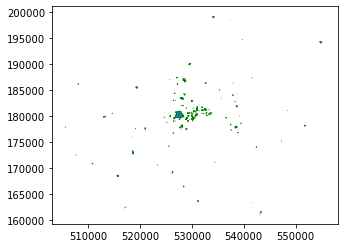

In [7]:
#Extract attractions location data, change to the same crs and plot
attractions = osm[(osm.fclass == 'attraction')]
attractions = attractions.to_crs('epsg:27700')
attractions.plot(edgecolor='green')

<AxesSubplot:>

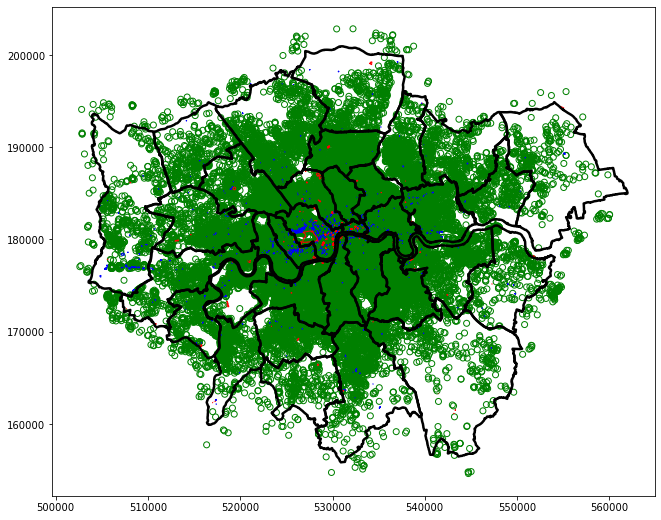

In [8]:
#Put everything in the same map to observe their locations. 
#I notice there are much more airbnb listings than hotels, with much broader scales.
#This part may take around 2 minutes to run
fig, ax = plt.subplots(1,1, figsize=(12,9))
gdf.plot(edgecolor="green", facecolor='none', ax=ax)
hotel.plot(edgecolor="blue", facecolor='none', ax=ax)
attractions.plot(edgecolor="red", facecolor='none', ax=ax)
london.plot(edgecolor="black", facecolor='none', linewidth=2.5, ax=ax)

<AxesSubplot:ylabel='Frequency'>

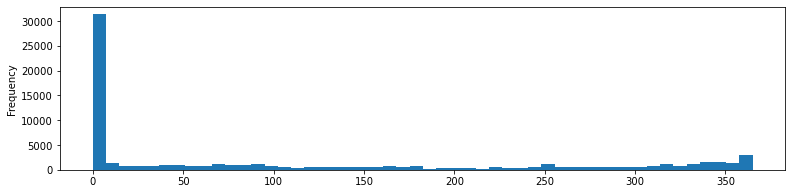

In [9]:
#Check the availabity of listings in 365 days. 
gdf.availability_365.plot.hist(bins=50, figsize=(13,3))
#Most of the listings are occupied most of the year

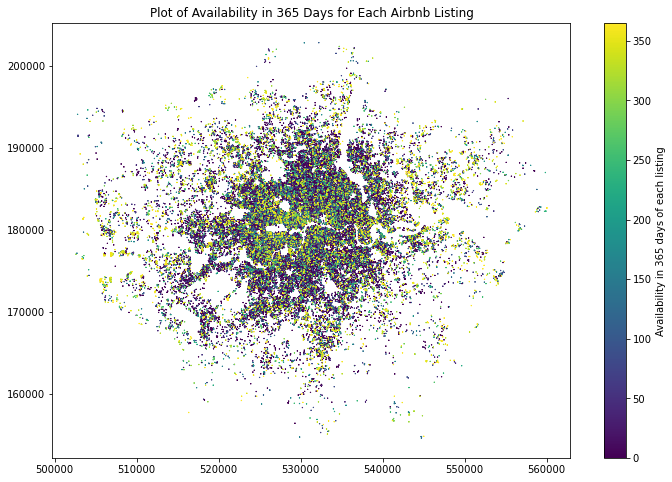

In [56]:
#Plot the listings and mark them with the availability data
ax = gdf.plot(figsize=(12,8), marker='*', markersize=0.25, 
         column='availability_365', cmap='viridis', 
         legend=True, legend_kwds={'label':'Availability in 365 days of each listing'});
ax.set_title("Plot of Availability in 365 Days for Each Airbnb Listing");

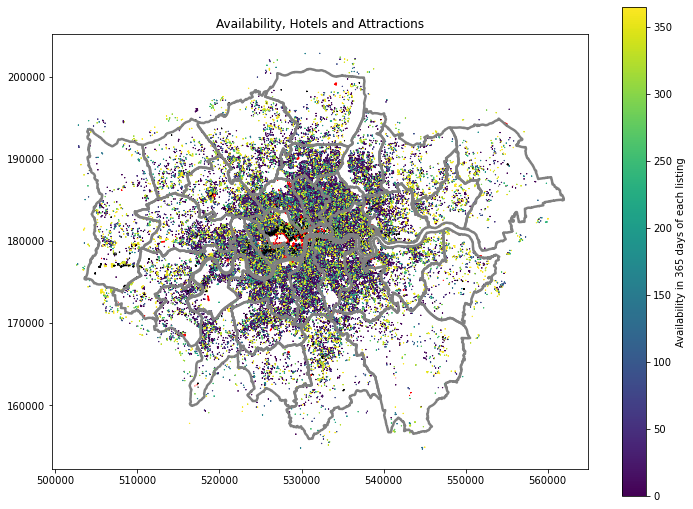

In [24]:
#Put everything together to see if the availability is related to the location of hotels and attractions.
#This part may also take around 2 minutes to run
fig, ax = plt.subplots(1,1, figsize=(12,9))
gdf.plot(marker='*', markersize=0.25, 
         column='availability_365', cmap='viridis', 
         legend=True, legend_kwds={'label':'Availability in 365 days of each listing'}, ax=ax)
hotel.plot(edgecolor="black", facecolor='none',ax=ax)
attractions.plot(edgecolor="red", facecolor='none',ax=ax)
london.plot(edgecolor="grey", facecolor='none', linewidth=2.5, ax=ax)
ax.set_title("Availability, Hotels and Attractions")
plt.savefig('availability, hotels, and attractions.png', dpi=150)

In [ ]:
### ucfnply code:

In [ ]:
print("start from here")

In [ ]:
### ucfnjin code:

In [ ]:
print("start from here")